<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Image_Diffusion_(working)/Spiral_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install einops
!pip install equinox
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 11.2 MB/s eta 0:00:00


In [5]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

#import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx
import numpy as np

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import optax
# import jax
# import jax.numpy as jnp
# import jax.random as jr
# %matplotlib inline
# import time
# import pylab as pl
# from IPython import display
# from tqdm.notebook import trange, tqdm
# import functools as ft
# import einops

In [6]:
# Data hyper-parameters
N = 1024  # nr of datapoints
vocab_size = 256

# Noise schedule hyper-parameters
beta_min = -8.0  
beta_max = 5.0  

key = jax.random.PRNGKey(seed=2023)
np.random.seed(2023)

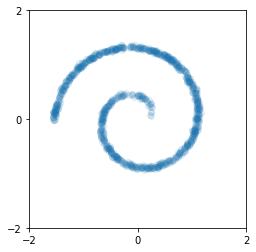

In [9]:
theta = np.sqrt(np.random.rand(N)) * 3 * np.pi  # we generate an array of shape (1024,) such that it they are uniform random numbers in [0,1) and then apply a bunch of operatrions on it
r_a = 0.07 * (2 * theta + np.pi) #mutiply by trig function below by some constant r_a
x = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T #here we produce two rows now of 1024 numbers that have been put through either function respectively - then tranpose so the shape ends up being (1024,2)

x = x + 0.02 * np.random.randn(N, 2) #again we multiply by a bunch of uniform random numbers of the right broadcasting shape

plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(x[:, 0], x[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

# Get mean and standard deviation of 'x'
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)

In [10]:
def beta(t):
    b = beta_min
    w = beta_max - beta_min
    return w * t + b

In [11]:
def plot(data, color="blue"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    plt.scatter(data[:, 0], data[:, 1], alpha=0.1, c=color)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

In [12]:
def sample_q_t_x( t, x, key=key):
    t *= jnp.ones((1,)) #convert t to a (1,) dimension array
    var_t = jax.nn.sigmoid(beta(t))[:, None] #jax function to get sigmoid
    eps = jax.random.normal(key, shape=x.shape)
    z_t = jnp.sqrt(1.0 - var_t) * x + jnp.sqrt(var_t) * eps #this is simply the reparamterisation
    return z_t

In [66]:
# rng1, rng2, rng3, rng4 = jax.random.split(key , 4)

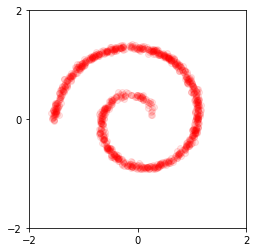

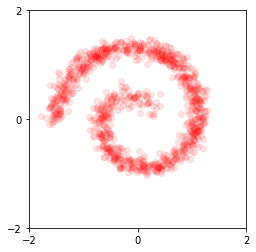

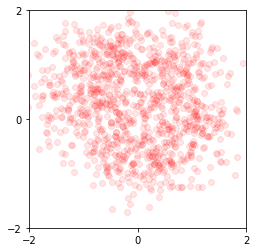

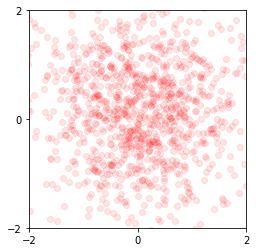

In [13]:
t=0.0
while t < 1.0:
  plot(sample_q_t_x( t, x, key), color="red")
  t += 0.25

In [14]:
def log_q_t_z(z, t):
    # t: scalar timestep
    # z: [B, D], points to evaluate on - theis comes from the meshgrid
    # x: [N, D], dataset
    # D: data dimensionality
    # var_t = jax.nn.sigmoid(beta(t))[None, None, None] #simply produces an array of one particular value
    # means_t = jnp.sqrt(1.0 - var_t) * x[None, :, :] 
    var_t = jax.nn.sigmoid(beta(t))
    var_t = einops.rearrange(var_t, "  -> 1 1 1")

    
    nx = einops.rearrange(x, " n d -> 1 n d")
    means_t = jnp.sqrt(1.0 - var_t)*nx

    nz  = einops.rearrange(z, "b d -> b 1 d")
    
    log_q = (nz - means_t) ** 2 / var_t + jnp.log(var_t * 2 * jnp.pi)
    #print(log_q.shape)
    log_q *= -0.5
    
    
    #log_q = log_q.sum(axis=2) 
    log_q = einops.reduce(log_q, "b n d -> b n", "sum")#essentially gets rid of the last dimension
    #print(log_q.shape)

    # Mixture of Gaussians, N is number of mixture components
    N = x.shape[1] #we should just recover our N which was orginally 1024
    log_q = jax.scipy.special.logsumexp(log_q - jnp.log(N), axis=1)

    return log_q


In [15]:
def plot_density(t):
    k = 100
    _x = jnp.linspace(-2, 2, k)  # , endpoint=False)
    _y = jnp.linspace(-2, 2, k)  # , endpoint=False)
    xs, ys = jnp.meshgrid(_x, _y)
    xys = jnp.vstack([xs.ravel(), ys.ravel()]).T
    q_t_x = jnp.exp(log_q_t_z(xys, t))
    q_t_x = q_t_x.reshape((k, k))

    plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
    plt.contourf(_x, _y, q_t_x, 20, cmap="Greys")
    plt.xticks([-2, 0, 2])
    plt.yticks([-2, 0, 2])

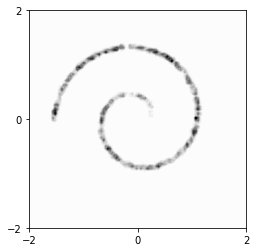

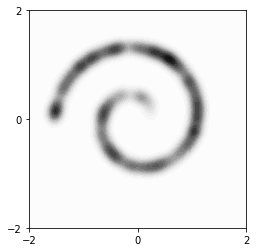

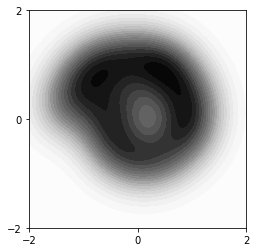

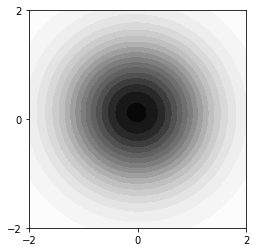

In [16]:
t=0.0
while t < 1.0:
  plot_density(t)
  t += 0.25

In [17]:
def plot_quiver(f):
    k = 20
    _x = jnp.linspace(-2, 2, k)  # , endpoint=False)
    _y = jnp.linspace(-2, 2, k)  # , endpoint=False)
    xs, ys = jnp.meshgrid(_x, _y)  #this divides the vectors above nicely into a matrix of rows and columns respescting the dimnesion specified above
    xys = jnp.vstack([xs.ravel(), ys.ravel()]).T #vstack concatenates along the first axis an array that has been reshaped from (N,) to (1,N) - then we transpose it back to (N,1)
    #print(xys.shape)
    gradients = f(xys) #f will be our grad function

    plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
    plt.quiver(xys[:, 0], xys[:, 1], gradients[:, 0], gradients[:, 1], width=0.005) #recall that we have both the positions in the vector field and the vector/directions which here will be the gradients
    plt.xticks([-2, 0, 2])
    plt.yticks([-2, 0, 2])


In [18]:
f_score = jax.grad(lambda z, t: log_q_t_z(z, t).sum()) #so we take the grad not of the function log, but of the mapping! Also this is summing over the array of size (400,) so the output is a scalar

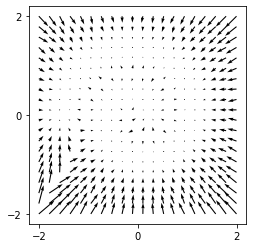

In [19]:
plot_quiver(ft.partial(f_score, t=0.0))

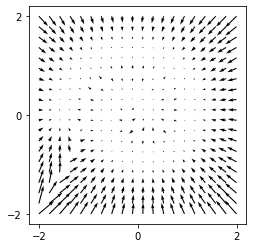

In [20]:
plot_quiver(ft.partial(f_score, t=0.25))

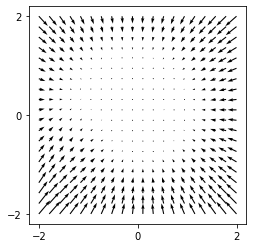

In [21]:
plot_quiver(ft.partial(f_score, t=0.5))

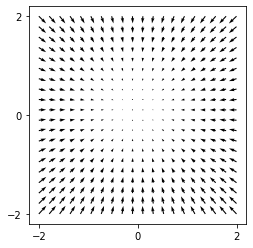

In [22]:
plot_quiver(ft.partial(f_score, t=0.75))

In [42]:
class NeuralNet(eqx.Module):
  main_net: eqx.nn.MLP

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)

  def __call__(self, y):
    y = self.main_net(y)
    return y

In [40]:
# rng = jr.PRNGKey(2023)

In [43]:
model = NeuralNet(2, 2, 256, 3, key)

In [44]:
model

NeuralNet(
  main_net=MLP(
    layers=[
      Linear(
        weight=f32[256,2],
        bias=f32[256],
        in_features=2,
        out_features=256,
        use_bias=True
      ),
      Linear(
        weight=f32[256,256],
        bias=f32[256],
        in_features=256,
        out_features=256,
        use_bias=True
      ),
      Linear(
        weight=f32[256,256],
        bias=f32[256],
        in_features=256,
        out_features=256,
        use_bias=True
      ),
      Linear(
        weight=f32[2,256],
        bias=f32[2],
        in_features=256,
        out_features=2,
        use_bias=True
      )
    ],
    activation=<wrapped function relu>,
    final_activation=<function _identity>,
    in_size=2,
    out_size=2,
    width_size=256,
    depth=3
  )
)

## Attempt

In [47]:
# Data hyper-parameters
N = 1024  # nr of datapoints

key = jax.random.PRNGKey(seed=2023)
np.random.seed(2023)

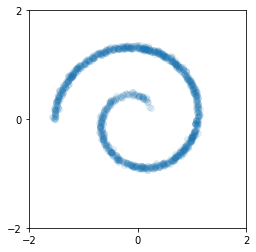

In [48]:
theta = np.sqrt(np.random.rand(N)) * 3 * np.pi  # we generate an array of shape (1024,) such that it they are uniform random numbers in [0,1) and then apply a bunch of operatrions on it
r_a = 0.07 * (2 * theta + np.pi) #mutiply by trig function below by some constant r_a
x = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T #here we produce two rows now of 1024 numbers that have been put through either function respectively - then tranpose so the shape ends up being (1024,2)

x = x + 0.02 * np.random.randn(N, 2) #again we multiply by a bunch of uniform random numbers of the right broadcasting shape

plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(x[:, 0], x[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

# Get mean and standard deviation of 'x'
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)

In [49]:
beta_min = 0.001
beta_max = 3

def beta_t(t):
    """
    t: time (number)
    returns beta_t as explained above
    """
    return beta_min + t*(beta_max - beta_min)

def alpha_t(t):
    """
    t: time (number)
    returns alpha_t as explained above
    """
    return t*beta_min + 0.5 * t**2 * (beta_max - beta_min)

def drift(x, t):
    """
    x: location of J particles in N dimensions, shape (J, N)
    t: time (number)
    returns the drift of a time-changed OU-process for each batch member, shape (J, N)
    """
    return -0.5*beta_t(t)*x

def dispersion(t):
    """
    t: time (number)
    returns the dispersion
    """
    return jnp.sqrt(beta_t(t))

def mean_factor(t):
    """
    t: time (number)
    returns m_t as above
    """
    return jnp.exp(-0.5 * alpha_t(t))

def var(t):
    """
    t: time (number)
    returns v_t as above
    """
    return 1 - jnp.exp(-alpha_t(t))

In [53]:
from functools import partial

In [54]:
R = 1000
train_ts = jnp.arange(1, R)/(R-1)

@partial(jax.jit, static_argnums=[1,2,3,4,5])
def reverse_sde(rng, N, n_samples, forward_drift, dispersion, score, ts=train_ts):

    def f(carry, params):
        t, dt = params
        x, rng = carry
        rng, step_rng = jr.split(rng)
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        noise = jr.normal(step_rng, x.shape)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return (x, rng), ()
    
    rng, step_rng = jr.split(rng)
    initial = jr.normal(step_rng, (n_samples, N))
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    (x, _), _ = jax.scan(f, (initial, rng), params)
    return x

In [55]:
class NeuralNet(eqx.Module):
  main_net: eqx.nn.MLP

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)

  def __call__(self, t, y):
    t = jnp.concatenate([t - 0.5, jnp.cos(2*jnp.pi*t)],axis=1)
    y = jnp.concatenate([y, t],axis=1)
    
    y = self.main_net(y)
    return y

In [60]:
model = NeuralNet(2, 2, 256, 3, key)

In [64]:
optimiser = optax.adam(1e-3)
opt_state = optimiser.init(eqx.filter(model, eqx.is_inexact_array))

In [65]:
# def loss_fn(model, rng, batch):
 
#     rng, step_rng = jr.split(rng)
#     N_batch = batch.shape[0]
#     t = jr.randint(step_rng, (N_batch,1), 1, R)/(R-1)
#     mean_coeff = mean_factor(t)
#     vs = var(t)
#     stds = jnp.sqrt(vs)
#     noise = jr.normal(step_rng, batch.shape)
#     xt = batch * mean_coeff + noise * stds
#     output = model(t,xt)
#     loss = jnp.mean((noise + output*vs)**2)
#     return loss

In [72]:
def single_loss_fn(model,rng,batch, t):
    rng, step_rng = jr.split(rng)
    #N_batch = batch.shape[0]
    #t = jr.randint(step_rng, (N_batch,1), 1, R)/(R-1)
    mean_coeff = mean_factor(t)
    vs = var(t)
    stds = jnp.sqrt(vs)
    noise = jr.normal(step_rng, batch.shape)
    xt = batch * mean_coeff + noise * stds
    output = model(t,xt)
    loss = jnp.mean((noise + output*vs)**2)
    
    return loss

In [73]:
def batch_loss_fn(model, rng,batch):
  N_batch = batch.shape[0]
  rng, step_rng = jr.split(rng)
  t = jr.randint(step_rng, (N_batch,1), 1, R)/(R-1)
  loss_fn = ft.partial(single_loss_fn, model)
  loss_fn = jax.vmap(loss_fn)
  return jnp.mean(loss_fn(rng, batch, t))

In [74]:
@eqx.filter_jit
def make_step(model,  data, key, opt_state):
    new_loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = new_loss_fn(model, key, data)
    updates, opt_state = optimiser.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_epochs = 10_000
train_size = x.shape[0]
batch_size = 5
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size
for k in range(N_epochs):
    rng, step_rng = jr.split(key)
    perms = jr.permutation(step_rng, train_size)
    perms = perms[:steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))
    losses = []
    for perm in perms:
        batch = x[perm, :]
        rng, step_rng = jr.split(rng)
        loss, model, opt_state = make_step(model, batch, step_rng, opt_state)
        losses.append(loss)
    mean_loss = jnp.mean(jnp.array(losses))
    if k % 1000 == 0:
        print("Epoch %d \t, Loss %f " % (k, mean_loss))